# Feedforward Neural Network Assignment

This notebook was produced with assistance from an LLM, following an iterative
development workflow.  
It implements:

- A synthetic **noisy XOR dataset**  
- A feed-forward neural network (**two-logit output**)  
- Training using **CrossEntropyLoss** and **Adam** optimizer  
- Mini-batch training using **PyTorch DataLoader**  
- Visualization of learned **decision boundaries** for both training and validation sets  

This corresponds to the assignment specification for building a complete
feedforward-learning pipeline in PyTorch.


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import random


In [35]:
class NoisyXORDataset(Dataset):
    """
    Noisy XOR dataset for CrossEntropyLoss.

    Each sample is generated around one of the four XOR centers:
        (0,0), (0,1), (1,0), (1,1)
    with Gaussian noise added.

    Labels:
        XOR(m1, m2) -> 0 or 1 (integer, required for CrossEntropyLoss)
    """

    def __init__(self, n_samples=2000, s=0.1):
        self.X = []
        self.y = []
        centers = [(0,0), (0,1), (1,0), (1,1)]

        for m1, m2 in centers:
            for _ in range(n_samples // 4):
                x1 = m1 + s * np.random.randn()
                x2 = m2 + s * np.random.randn()
                self.X.append([x1, x2])
                self.y.append(m1 ^ m2)  # XOR -> 0 or 1

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [36]:
class FFNN(nn.Module):
    """
    Feed-forward neural network with:
      - input dim = 2
      - two hidden layers with Tanh
      - output dim = 2 logits (for CrossEntropyLoss)
    """

    def __init__(self, width=16, depth=2):
        super().__init__()
        layers = []
        in_dim = 2

        for _ in range(depth):
            layers.append(nn.Linear(in_dim, width))
            layers.append(nn.Tanh())
            in_dim = width

        layers.append(nn.Linear(in_dim, 2))  # two logits -> CE
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [37]:
def plot_decision_boundary(model, dataset, title="Decision Boundary", h=0.02):
    model.eval()

    X = dataset.X
    y = dataset.y

    # grid for decision map
    x_min, x_max = X[:,0].min() - 0.2, X[:,0].max() + 0.2
    y_min, y_max = X[:,1].min() - 0.2, X[:,1].max() + 0.2

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    with torch.no_grad():
        logits = model(grid)
        pred = logits.argmax(dim=1).numpy()

    pred = pred.reshape(xx.shape)

    cmap = ListedColormap(["#FFBBBB", "#BBFFBB"])

    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, pred, cmap=cmap, alpha=0.6)

    # scatter data points
    plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(["red", "green"]), edgecolor='k')

    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()


In [38]:
# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Create full dataset
dataset = NoisyXORDataset(n_samples=2000, s=0.1)

# Train/val/test split: 70% / 15% / 15%
N = len(dataset)
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)


In [ ]:
model = FFNN(width=16, depth=2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [45]:
EPOCHS = 5

train_losses = []
val_losses   = []
val_accs     = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # ---- Validation ----
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()

            preds = logits.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1:02d}/{EPOCHS} "
          f"| Train Loss: {train_losses[-1]:.4f} "
          f"| Val Loss: {val_losses[-1]:.4f} "
          f"| Val Acc: {val_accs[-1]*100:.2f}%")
    



Epoch 01/5 | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 02/5 | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 03/5 | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 04/5 | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 05/5 | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss_total = 0
    with torch.no_grad():
        for x, y in loader:
            logits = model(x)
            loss_total += criterion(logits, y).item()
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return loss_total / len(loader), correct / total

In [42]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"TEST — Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")


TEST — Loss: 0.0000, Accuracy: 100.00%


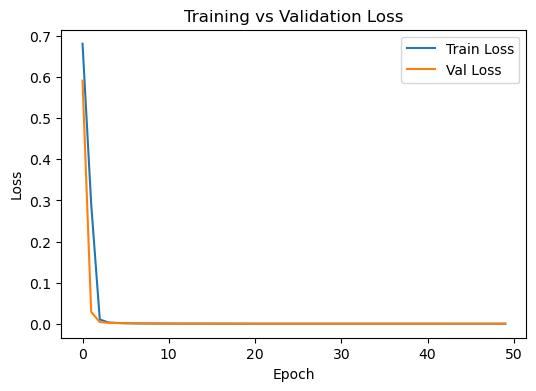

In [43]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


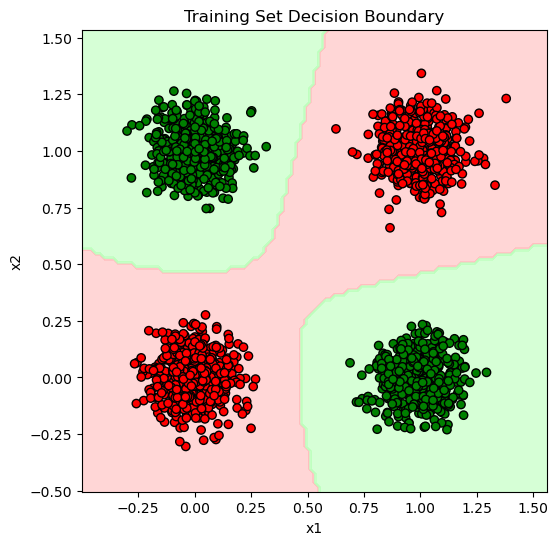

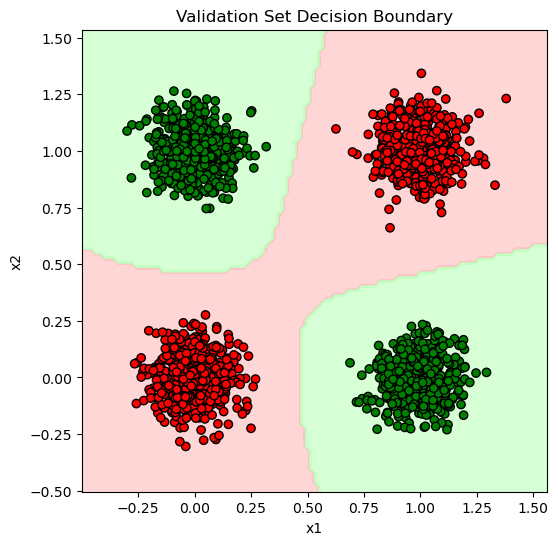

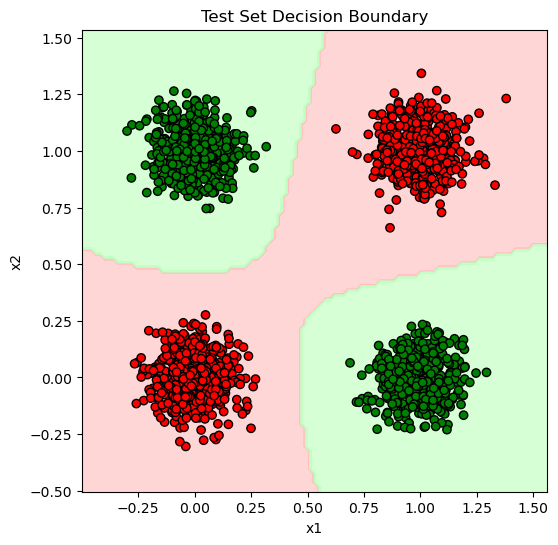

In [44]:
plot_decision_boundary(model, train_dataset.dataset, title="Training Set Decision Boundary")
plot_decision_boundary(model, val_dataset.dataset,   title="Validation Set Decision Boundary")
plot_decision_boundary(model, test_dataset.dataset, title="Test Set Decision Boundary")

There are two versions of the binary cross entropy loss function in PyTorch. What is the
difference, and which one should you use?

- https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss.forward.

- https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy. 

The compute the same loss, however the module version is integrated more into the PyTorch ecosystem.
torch.nn.functional.cross_entropy is a function call. Which is a more direct and manual approach.

prompt: cross entropy loss pytorch


Update feedforwardAssignment.ipynb such that it tests a range of networks for how well they can
classify the noisy-xor data source. As a minimum try repeatedly all combinations of 0...3 hidden
layers with widths 1...3. For each combination of depth and width, calculate the mean and
standard deviation of the resulting loss function on a new data set.

In [ ]:
num_models = 10
range_of_widths = [1, 2, 3]
range_of_depths = [0, 1, 2, 3]
Model_parameter_and_results = []
#seedless dataset.

for k, width in enumerate(range_of_widths):
    for l, depth in enumerate(range_of_depths):
        for i, model in enumerate(range(num_models)):
            model = FFNN(width=width, depth=depth)
            # Ensure reproducibility
            torch.manual_seed(i+k+l)
            np.random.seed(i+k+l)
            random.seed(i+k+l)

            # Create full dataset
            dataset = NoisyXORDataset(n_samples=2000, s=0.1)

            # Train/val/test split: 70% / 15% / 15%
            N = len(dataset)
            train_size = int(0.7 * N)
            val_size   = int(0.15 * N)
            test_size  = N - train_size - val_size

            train_dataset, val_dataset, test_dataset = random_split(
                dataset, [train_size, val_size, test_size]
            )

            # DataLoaders
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader   = DataLoader(val_dataset, batch_size=32)
            test_loader  = DataLoader(test_dataset, batch_size=32)

            EPOCHS = 100
            
            train_losses = []
            val_losses   = []
            val_accs     = []

            for epoch in range(EPOCHS):
                model.train()
                epoch_loss = 0
                for x_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    logits = model(x_batch)
                    loss = criterion(logits, y_batch)
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()

                train_losses.append(epoch_loss / len(train_loader))

                # ---- Validation ----
                model.eval()
                val_loss = 0
                correct = 0
                total = 0

                with torch.no_grad():
                    for x_batch, y_batch in val_loader:
                        logits = model(x_batch)
                        loss = criterion(logits, y_batch)
                        val_loss += loss.item()

                        preds = logits.argmax(dim=1)
                        correct += (preds == y_batch).sum().item()
                        total += y_batch.size(0)

                val_losses.append(val_loss / len(val_loader))
                val_accs.append(correct / total)

                print(f"Epoch {epoch+1:02d}/{EPOCHS} "
                    f"| Train Loss: {train_losses[-1]:.4f} "
                    f"| Val Loss: {val_losses[-1]:.4f} "
                    f"| Val Acc: {val_accs[-1]*100:.2f}%")
            model_list = [i, k, l]
            test_loss, test_acc = evaluate(model, test_loader)
            model_list.append(test_loss)
            model_list.append(test_acc)
            total_params = sum(
                        param.numel() for param in model.parameters()
                    )
            model_list.append(total_params)
            Model_parameter_and_results.append(model_list)
            print(f"TEST — Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")



Epoch 01/100 | Train Loss: 0.7782 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 02/100 | Train Loss: 0.7782 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 03/100 | Train Loss: 0.7780 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 04/100 | Train Loss: 0.7776 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 05/100 | Train Loss: 0.7790 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 06/100 | Train Loss: 0.7781 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 07/100 | Train Loss: 0.7790 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 08/100 | Train Loss: 0.7785 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 09/100 | Train Loss: 0.7788 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 10/100 | Train Loss: 0.7781 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 11/100 | Train Loss: 0.7786 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 12/100 | Train Loss: 0.7788 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 13/100 | Train Loss: 0.7785 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 14/100 | Train Loss: 0.7773 | Val Loss: 0.7493 | Val Acc: 54.33%
Epoch 

In [135]:
Model_parameter_and_results

[[0, 0, 0, 0.7180942237377167, 0.5133333333333333, 6],
 [1, 0, 0, 0.8945601463317872, 0.49, 6],
 [2, 0, 0, 0.8360646665096283, 0.49333333333333335, 6],
 [3, 0, 0, 0.7202260255813598, 0.7266666666666667, 6],
 [4, 0, 0, 0.8372561275959015, 0.48333333333333334, 6],
 [5, 0, 0, 0.762785804271698, 0.49666666666666665, 6],
 [6, 0, 0, 0.7068764388561248, 0.4533333333333333, 6],
 [7, 0, 0, 0.7345744132995605, 0.51, 6],
 [8, 0, 0, 0.7377362132072449, 0.33666666666666667, 6],
 [9, 0, 0, 0.7723074734210968, 0.5033333333333333, 6],
 [0, 0, 1, 0.7765189290046692, 0.51, 7],
 [1, 0, 1, 0.6983307778835297, 0.36, 7],
 [2, 0, 1, 0.7131233870983124, 0.52, 7],
 [3, 0, 1, 0.7376086235046386, 0.5166666666666667, 7],
 [4, 0, 1, 0.7029762864112854, 0.49666666666666665, 7],
 [5, 0, 1, 0.7944888830184936, 0.5233333333333333, 7],
 [6, 0, 1, 0.719672417640686, 0.49, 7],
 [7, 0, 1, 0.7086627006530761, 0.5166666666666667, 7],
 [8, 0, 1, 0.7320815682411194, 0.5033333333333333, 7],
 [9, 0, 1, 0.7849525272846222, 0.493

In [139]:
element_loss = [entry[3] for entry in Model_parameter_and_results]
element_name = [entry[1:3] for entry in Model_parameter_and_results]
element_accuracy = [entry[4] for entry in Model_parameter_and_results]
element_paramter = [entry[5] for entry in Model_parameter_and_results]
#add 1 to width and depth for display purposes
element_name = list(map(lambda t: (t[0] + 1, t[1]), element_name))

for j, i in enumerate(range(len(range_of_depths)*len(range_of_widths))):
    model_iteration_loss = []
    model_iteration_loss.append(element_loss[i*10:(i+1)*10])
    model_iteration_accuracy = []
    model_iteration_accuracy.append(element_accuracy[i*10:(i+1)*10])
    model_iteration_parameter = []
    model_iteration_parameter.append(element_paramter[i*10:(i+1)*10])
    print(f"Loss for model iteration {i+1} {element_name[i*10]} = {np.mean(model_iteration_loss):.2f} And with a STD of = {np.std(model_iteration_loss):.2f} and with total number of paremeters = {np.mean(model_iteration_parameter)} and acc {np.mean(model_iteration_accuracy):.2f}" )
    

Loss for model iteration 1 (1, 0) = 0.77 And with a STD of = 0.06 and with total number of paremeters = 6.0 and acc 0.50
Loss for model iteration 2 (1, 1) = 0.74 And with a STD of = 0.03 and with total number of paremeters = 7.0 and acc 0.49
Loss for model iteration 3 (1, 2) = 0.86 And with a STD of = 0.10 and with total number of paremeters = 9.0 and acc 0.50
Loss for model iteration 4 (1, 3) = 0.75 And with a STD of = 0.07 and with total number of paremeters = 11.0 and acc 0.50
Loss for model iteration 5 (2, 0) = 0.76 And with a STD of = 0.04 and with total number of paremeters = 6.0 and acc 0.50
Loss for model iteration 6 (2, 1) = 0.76 And with a STD of = 0.04 and with total number of paremeters = 12.0 and acc 0.52
Loss for model iteration 7 (2, 2) = 0.78 And with a STD of = 0.09 and with total number of paremeters = 18.0 and acc 0.50
Loss for model iteration 8 (2, 3) = 0.76 And with a STD of = 0.09 and with total number of paremeters = 24.0 and acc 0.50
Loss for model iteration 9 (

In [ ]:
#best model 
best_model_index = np.argmin(element_loss)
best_model_info = Model_parameter_and_results[best_model_index]
print(f"Best Model - Index: {best_model_index}, Width: {best_model_info